Oliver W. Layton

Fall 2022

CS343: Neural Networks

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

plt.show()
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

C:\Users\wenmu\AppData\Local\Temp\ipykernel_864\3855634337.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
C:\Users\wenmu\AppData\Local\Temp\ipykernel_864\3855634337.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])


# TensorFlow 2 tutorial

It is important that you have TensorFlow 2 installed. Version 2.9, 2.10, or 2.11 should work fine. Older versions 1.X will NOT work for this class and are completely incompatible.

You can install it on your laptop via [pip](https://cs.colby.edu/courses/F22/cs343/software.html#np). *It might already be installed if you followed the software installation instructions at the beginning of the semester.*


#### Optional: TensorFlow with GPU acceleration

The following instructions allow you install the GPU version of TensorFlow on certain systems. This is **NOT** necessary! The advantage is that it can speed up your code substantially, but **the installation process is harder and more complicated**. GPU accleration is an option you have the following systems:
- [macOS with Apple Silicon](https://cs.colby.edu/courses/F22/cs343/software.html#tf )
- [Windows or Linux with NVIDIA graphics card](https://cs.colby.edu/courses/F22/cs343/software.html#gpuInstall)

Even if you have one of these systems, you do not need to do this. The above pip method will work fine for everyone.

#### TensorFlow 2 API

**Super, super helpful reference:** https://www.tensorflow.org/api_docs/python/tf

#### WARNING

Non-tensorflow.org code/references online/textbooks may still assume tensorflow 1.X. Be careful to not get confused with incompatibility.

In [3]:
cash = np.array([25000, 30000, 24600, 142400])
print(np.sum(cash))

cash_neg = np

222000


## TensorFlow installation test

The following should print something like:

    Tensorflow version 2.10.0

In [24]:
import tensorflow as tf

print('Tensorflow version', tf.__version__)

Tensorflow version 2.11.0


## 1: Tensorflow's high level Keras Sequential API

- Very high level.
- Allows you to configure common network layers with netIn/netAct in very few lines of code.
- Abstracts away wt/bias initializtion, performance metric calculation, training loop, etc.
- Useful for prototyping/trying different network architectures to solve a problem without investing time to implement lots of code specific to each netIn/netAct/num layers.

The following functions are commonly used in the Keras Sequential API:

- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

### Implementing MLP in `Keras::Sequential` 

    Dense netIn / ReLu netAct ->
    Dense netIn / Sigmoid netAct ->
    Dense netIn / Softmax netAct (input has C classes)

#### Set up test "RGB image" inputs

- Even though we have MLP, let's setup shape as 4D and have net handle flattening.
- Let's also define a random test and validation set

In [25]:
N_train = 100
N_test = 50
N_val = 50
img_y = 32
img_x = 32
n_chans = 3
C = 10

# gaussian inputs
inputs = np.random.normal(size=(N_train, img_y, img_x, n_chans))

# gaussian test inputs
inputs_test = np.random.normal(size=(N_test, img_y, img_x, n_chans))

# gaussian validation inputs
inputs_val = np.random.normal(size=(N_val, img_y, img_x, n_chans))

# classes need to be Nx1 for broadcast-ability later on
y = np.random.randint(low=0, high=C, size=(N_train, 1))
y_test = np.random.randint(low=0, high=C, size=(N_test, 1))
y_val = np.random.randint(low=0, high=C, size=(N_val, 1))

print(f'Training samples have shape {inputs.shape}')
print(f'Class assignments:\n{y}')

Training samples have shape (100, 32, 32, 3)
Class assignments:
[[5]
 [0]
 [7]
 [3]
 [3]
 [0]
 [5]
 [9]
 [4]
 [1]
 [0]
 [2]
 [2]
 [4]
 [5]
 [8]
 [0]
 [2]
 [3]
 [7]
 [8]
 [0]
 [3]
 [3]
 [8]
 [3]
 [9]
 [5]
 [6]
 [8]
 [9]
 [4]
 [7]
 [4]
 [7]
 [6]
 [4]
 [9]
 [3]
 [4]
 [7]
 [5]
 [7]
 [8]
 [7]
 [0]
 [7]
 [9]
 [2]
 [7]
 [9]
 [2]
 [2]
 [3]
 [4]
 [5]
 [2]
 [9]
 [3]
 [2]
 [0]
 [6]
 [9]
 [8]
 [7]
 [7]
 [2]
 [4]
 [1]
 [3]
 [4]
 [9]
 [7]
 [3]
 [3]
 [5]
 [6]
 [8]
 [3]
 [3]
 [2]
 [5]
 [3]
 [7]
 [6]
 [7]
 [5]
 [3]
 [0]
 [8]
 [7]
 [2]
 [5]
 [8]
 [5]
 [4]
 [8]
 [4]
 [6]
 [0]]


#### Step 1) `Keras::Sequential`  network construction

Idea: Make a sequential list of layer objects.

**NOTES:**
- `Dense` layers should have 1D input (i.e. a feature vector). Options for image input:
    1. Specify 3D image dims in input layer, then include `Flatten` layer (*layer that does nothing but pass through flattened version of its input*).
    2. Flatten data as preprocessing step to shape `(N, M)`.
- `Flatten` layer needed when Conv/Pooling layers and Dense MLP layers in a CNN.
- Input layer shape **does not include (leading) batch dimension**.
- Easy to check a summary of the network architecture afterwards.

##### Regularization

If you want to add regularization (*optional*), you add to following option to any layer you'd like to regularize:

```
kernel_regularizer=tf.keras.regularizers.l2(l=reg)
```

Let's regularize the hidden layers.

##### Summary of net architecture

    Dense netIn / ReLu netAct ->
    Dense netIn / Sigmoid netAct ->
    Dense netIn / Softmax netAct (input has C classes)

In [26]:
H1 = 10  # num hidden units in L1 (1st hidden layer)
H2 = 30  # num hidden units in L2 (2nd hidden layer)
reg = 0.5  # Regularization strength in hidden layers

In [27]:
img_y*img_x*n_chans

3072

In [28]:
# NO REG:
net = tf.keras.Sequential(
    [tf.keras.layers.Input(shape=(img_y, img_x, n_chans)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=H1, activation='relu'),
    tf.keras.layers.Dense(units=H2, activation='sigmoid'),
    tf.keras.layers.Dense(units=C, activation='softmax')]
)
net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                30730     
                                                                 
 dense_2 (Dense)             (None, 30)                330       
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
Total params: 31,370
Trainable params: 31,370
Non-trainable params: 0
_________________________________________________________________


In [29]:
net2 = tf.keras.Sequential(
    [tf.keras.layers.Input(shape=(img_y, img_x, n_chans)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=H1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=reg)),
    tf.keras.layers.Dense(units=H2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=reg)),
    tf.keras.layers.Dense(units=C, activation='softmax')]
)
net2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                30730     
                                                                 
 dense_5 (Dense)             (None, 30)                330       
                                                                 
 dense_6 (Dense)             (None, 10)                310       
                                                                 
Total params: 31,370
Trainable params: 31,370
Non-trainable params: 0
_________________________________________________________________


#### Step 2) Compile `Keras::Sequential`  network object

Like in the CNN project, `model.compile` allows us to specify the optimizer. For TensorFlow, we also specify the loss and the performance metrics we want `Keras` to keep track of for us (remember, we abstract away the training loop, so we can't add calls to compute accuracy/loss when we want).

Lets use:
- Optimizer: adam https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- Loss: cross entropy loss appropriate for int-coded classes ("sparse categorical") (not one-hot coded). https://www.tensorflow.org/api_docs/python/tf/keras/losses
- Metrics: accuracy https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [30]:
net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
net2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Step 3) Fit model 

Common things to set:
- batch size (25)
- num epochs (150)
- validation data (optional)

In [31]:
hist = net.fit(inputs, y, batch_size=25, epochs=150, validation_data=(inputs_val, y_val))
hist2 = net2.fit(inputs, y, batch_size=25, epochs=160, validation_data=(inputs_val, y_val))

Epoch 1/150
4/4 [==============================] - 1s 53ms/step - loss: 2.5769 - accuracy: 0.0900 - val_loss: 2.5831 - val_accuracy: 0.1200
Epoch 2/150
4/4 [==============================] - 0s 12ms/step - loss: 2.3101 - accuracy: 0.0900 - val_loss: 2.5594 - val_accuracy: 0.1200
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 2.1711 - accuracy: 0.0900 - val_loss: 2.5416 - val_accuracy: 0.1200
Epoch 4/150
4/4 [==============================] - 0s 13ms/step - loss: 2.0612 - accuracy: 0.1300 - val_loss: 2.5256 - val_accuracy: 0.1200
Epoch 5/150
4/4 [==============================] - 0s 13ms/step - loss: 1.9824 - accuracy: 0.2200 - val_loss: 2.5139 - val_accuracy: 0.1200
Epoch 6/150
4/4 [==============================] - 0s 13ms/step - loss: 1.9163 - accuracy: 0.3100 - val_loss: 2.5062 - val_accuracy: 0.1200
Epoch 7/150
4/4 [==============================] - 0s 12ms/step - loss: 1.8615 - accuracy: 0.3600 - val_loss: 2.4998 - val_accuracy: 0.1200
Epoch 8/150
4/4 [===

#### Step 4) Plot training performance metrics using history output

Common metrics:
- loss
- accuracy
- val_accuracy
- val_loss

In [32]:
print(hist.history.keys())
print(hist2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


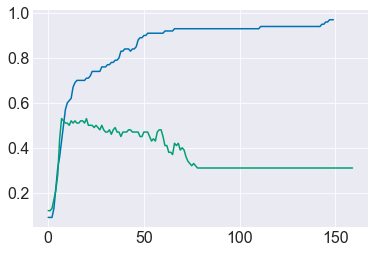

In [33]:
# without any reg
plt.plot(hist.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.show()

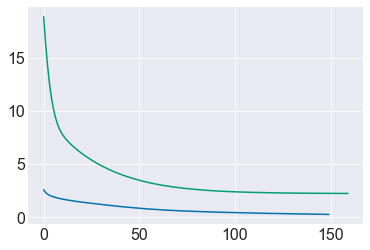

In [34]:
# without reg
plt.plot(hist.history['loss'])
plt.plot(hist2.history['loss'])
plt.show()

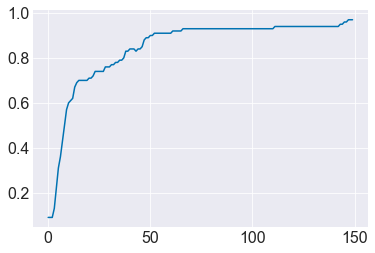

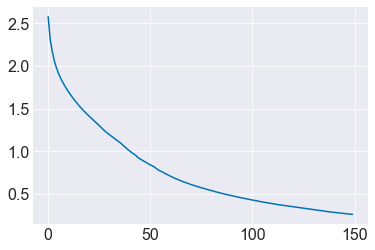

In [35]:
# with reg
plt.plot(hist.history['accuracy'])
plt.show()
plt.plot(hist.history['loss'])
plt.show()

#### Step 5) Evaluate network on test set

In [36]:
loss, acc = net.evaluate(inputs_test, y_test)
print(f'Test loss {loss} and accuracy {acc}')

2/2 [==============================] - 0s 0s/step - loss: 2.9616 - accuracy: 0.0400
Test loss 2.9615817070007324 and accuracy 0.03999999910593033


#### Step 6) (optional) Get class probabilities of test input

- `predict()` method

1/1 [==============================] - 0s 31ms/step
(2, 10)


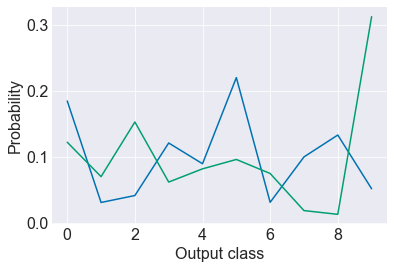

In [41]:
output_netActs = net.predict(inputs_test[:2])
print(output_netActs.shape)
plt.plot(output_netActs.T)
plt.xlabel('Output class')
plt.ylabel('Probability')
plt.show()

In [42]:
np.sum(output_netActs, axis=1)

array([1., 1.], dtype=float32)

## 2: Transfer learning with pre-trained models

- As you now know first-hand, training a deep neural network can take lots of time! Fortunately, you often don't need to train a large CNN yourself. - Tensorflow makes it easy to download pre-trained `Keras::Sequential` models published by researchers. Here is a list of ones easily downloadable: https://www.tensorflow.org/api_docs/python/tf/keras/applications
- You can download these models and run your data thru them easily. We will use the `MobileNetV2` model here.
- **Problem:** This is fine if you are classifying the same dataset used by the researchers who trained the net...but your problem will usually differ from theirs. You can't expect the network to perform well at handwriting recognition (e.g. MNIST) if the net was trained on outdoor images (e.g. ImageNet). 
- **Solution:** If you have a dataset that is similar to that used in a pre-trained model (e.g. classifying flower types here), we can do something called **transfer learning** to try and repurpose parts of the pre-trained net and make small changes to adapt it to our application.

### Load flower dataset

In [3]:
import load_flower_dataset

In [4]:
flower_x, flower_y, flower_yh, class_names = load_flower_dataset.load()
input_nonbatch_shape = flower_x.shape[1:]
C = len(class_names)

print(f'Flower dataset shape: {flower_x.shape}')
print(f'Flower one-hot coded classes shape: {flower_yh.shape}')
print(f'Flower class names: {class_names}')

Processing daisy 633 images
Processing dandelion 898 images
Processing roses 641 images
Processing sunflowers 699 images
Processing tulips 799 images
Flower dataset shape: (3670, 224, 224, 3)
Flower one-hot coded classes shape: (3670, 5)
Flower class names: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


### Visualize images next to ground-truth labels

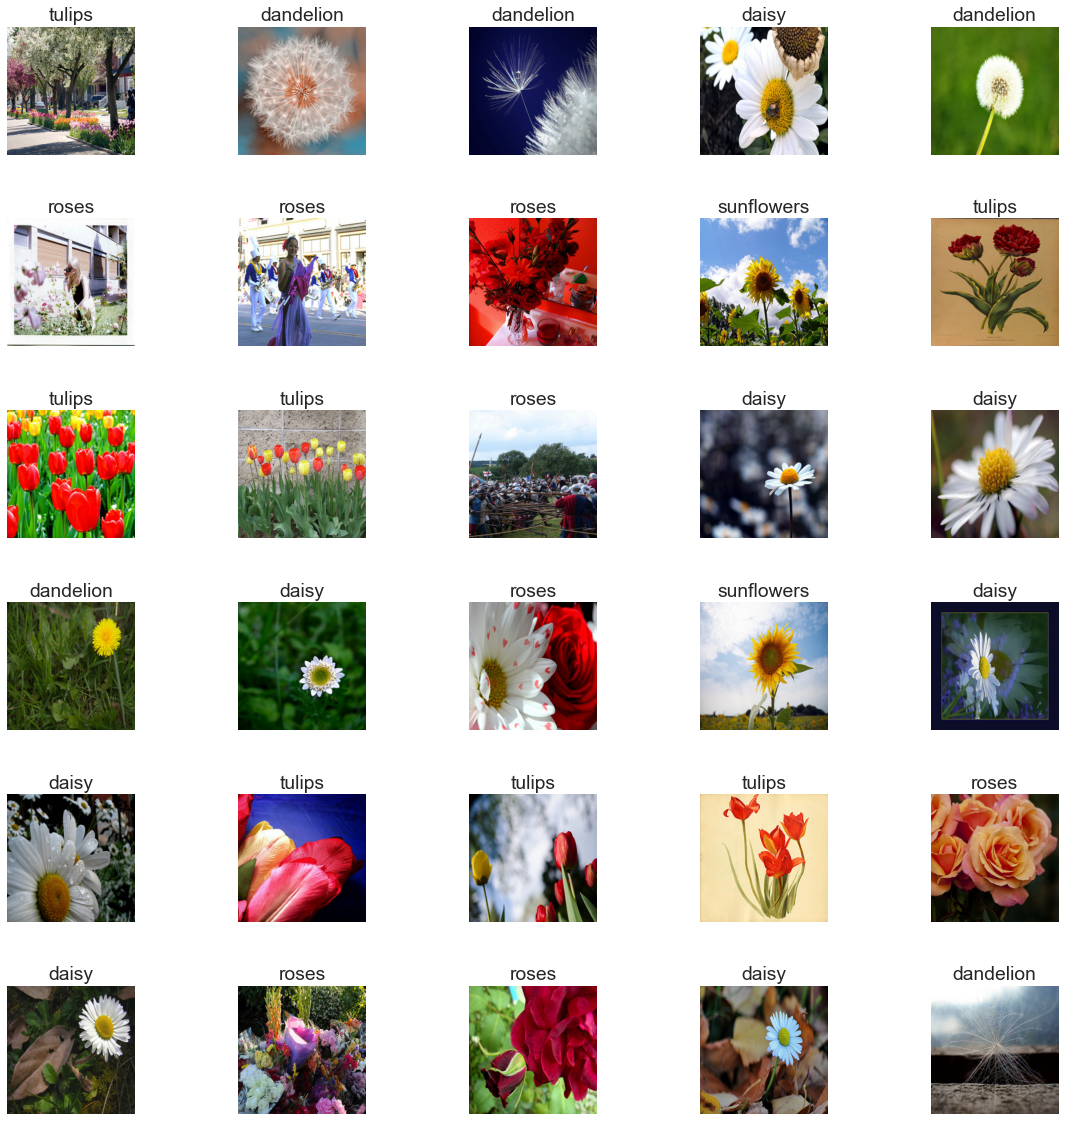

In [5]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(flower_x[n])
  plt.title(class_names[flower_y[n]])
  plt.axis('off')
plt.show()

### Load in MobileNetV2

This pretrained net (and others) provided in TF Keras in: `tf.keras.applications`

Make sure it can't be trained (i.e. pretrained weights are frozen and can't be changed).

Just like with `Input` Layer object, we exclude batch dimension when providing `input_shape`.

**Note:** Look at output layer. It can't be used with our flowers dataset!

In [6]:
input_nonbatch_shape

(224, 224, 3)

In [9]:
pretrained_net = tf.keras.applications.MobileNetV2(input_shape=input_nonbatch_shape,
                                                  weights='imagenet')
pretrained_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Do surgery on the net: chop off trained output layer, tack on new untrained `Dense` output layer (`C` neurons)

#### Load in MobileNetV2 without the classification layer (output layer)

In [10]:
pretrained_net = tf.keras.applications.MobileNetV2(input_shape=input_nonbatch_shape,
                                                  include_top=False,
                                                  weights='imagenet')
pretrained_net.trainable = False
pretrained_net.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

#### Tack on new Dense layer with `C` neurons

We created as an **augmented model** with new output layer using the same `keras::Sequential` API.

Remember to specify output layer activation function!

In [11]:
aug_net = tf.keras.Sequential(
    [
        pretrained_net,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=C, activation='softmax')
    ]
)
aug_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 5)                 313605    
                                                                 
Total params: 2,571,589
Trainable params: 313,605
Non-trainable params: 2,257,984
_________________________________________________________________


#### Compile the net

Use:
- adam optimizer
- categorical_crossentropy loss (for softmax / one-hot coded classes)
- metrics: accuracy 

In [12]:
# Compile model with adam optimizer, categorical_crossentropy, accuracy
# look at summary for number of trainable wts (should be output layer only)
aug_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Evaluate net accuracy with new top layer with random weights

#### Evaluate accuracy with untrained classification (output) layer

- ~100 samples should be enough to gauge accuracy
- verbose option useful to control number of print outs
- **Remember:** with "categorical" (not sparse) crossentropy loss, the network needs one-hot class vectors!

In [13]:
loss, acc = aug_net.evaluate(flower_x[:100], flower_yh[:100])
print(f'Accuracy: {acc}, Loss: {loss}')

4/4 [==============================] - 6s 566ms/step - loss: 2.2941 - accuracy: 0.1600
Accuracy: 0.1599999964237213, Loss: 2.294098138809204


#### Check "out of box" predictions in augmented network with untrained output layer

Run on first 30 samples of training set.

In [14]:
# net_act for last layer
output_net_act = aug_net.predict(flower_x[:30])
output_net_act.shape

1/1 [==============================] - 2s 2s/step


(30, 5)

In [15]:
# Convert net_act to y_preds
y_preds = np.argmax(output_net_act, axis=1)
y_preds

array([4, 0, 2, 4, 1, 1, 4, 3, 4, 1, 3, 1, 4, 0, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 0, 3, 1, 1, 4, 0], dtype=int64)

In [16]:
# Get class names for the predicted class for each sample (oob_preds)
oob_preds = class_names[y_preds]

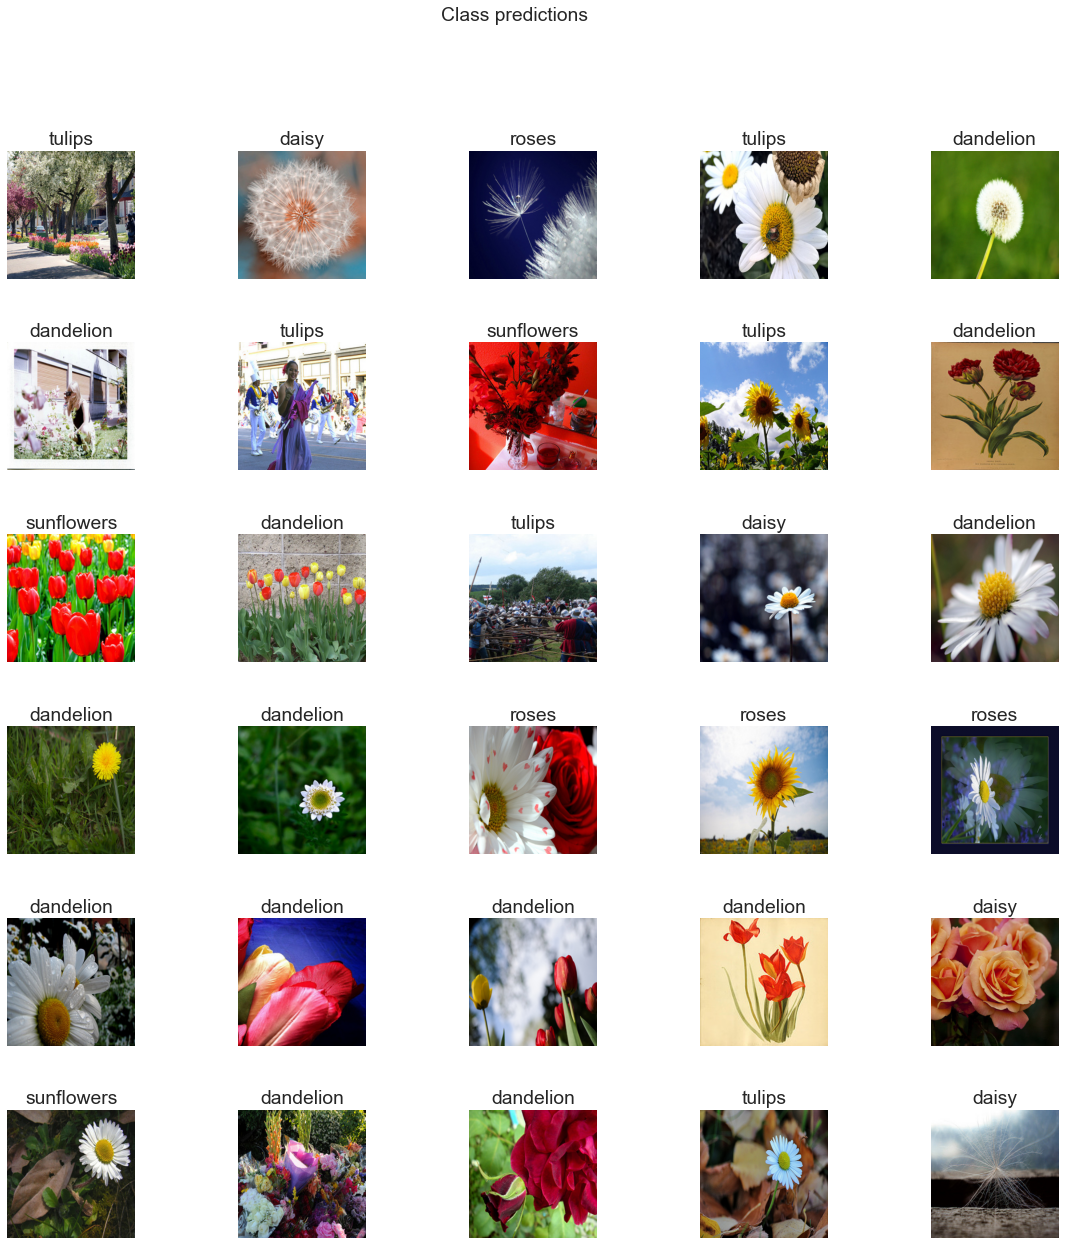

In [17]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(flower_x[n])
  plt.title(oob_preds[n])
  plt.axis('off')
  plt.suptitle("Class predictions")
plt.show()

### Fine-tune pretrained network

Train top layer **only**, keep pretrained network weights frozen.

#### Train the output layer wts only on the flower data

Train for 2 epochs (!!) and B = 32.

In [18]:
aug_net.fit(flower_x, flower_yh, epochs=2, batch_size=32)

Epoch 1/2
115/115 [==============================] - 67s 543ms/step - loss: 2.2191 - accuracy: 0.7834
Epoch 2/2
115/115 [==============================] - 44s 387ms/step - loss: 0.4965 - accuracy: 0.9392


#### Evaluate accuracy with trained classification (output) layer

Evaluate training acc on 1st 100 samples.

In [21]:
loss, acc = aug_net.evaluate(flower_x[:100], flower_yh[:100])
print(f'Accuracy: {acc}, Loss: {loss}')

4/4 [==============================] - 0s 97ms/step - loss: 0.0802 - accuracy: 0.9700
Accuracy: 0.9700000286102295, Loss: 0.08017972856760025


#### Visualize predicted labels next to input images

In [20]:
# get net_acts for first 30 training samples
net_acts = aug_net.predict(flower_x[:30])
# convert net_acts to class labels
preds = class_names[np.argmax(net_acts, axis=1)]

1/1 [==============================] - 0s 372ms/step


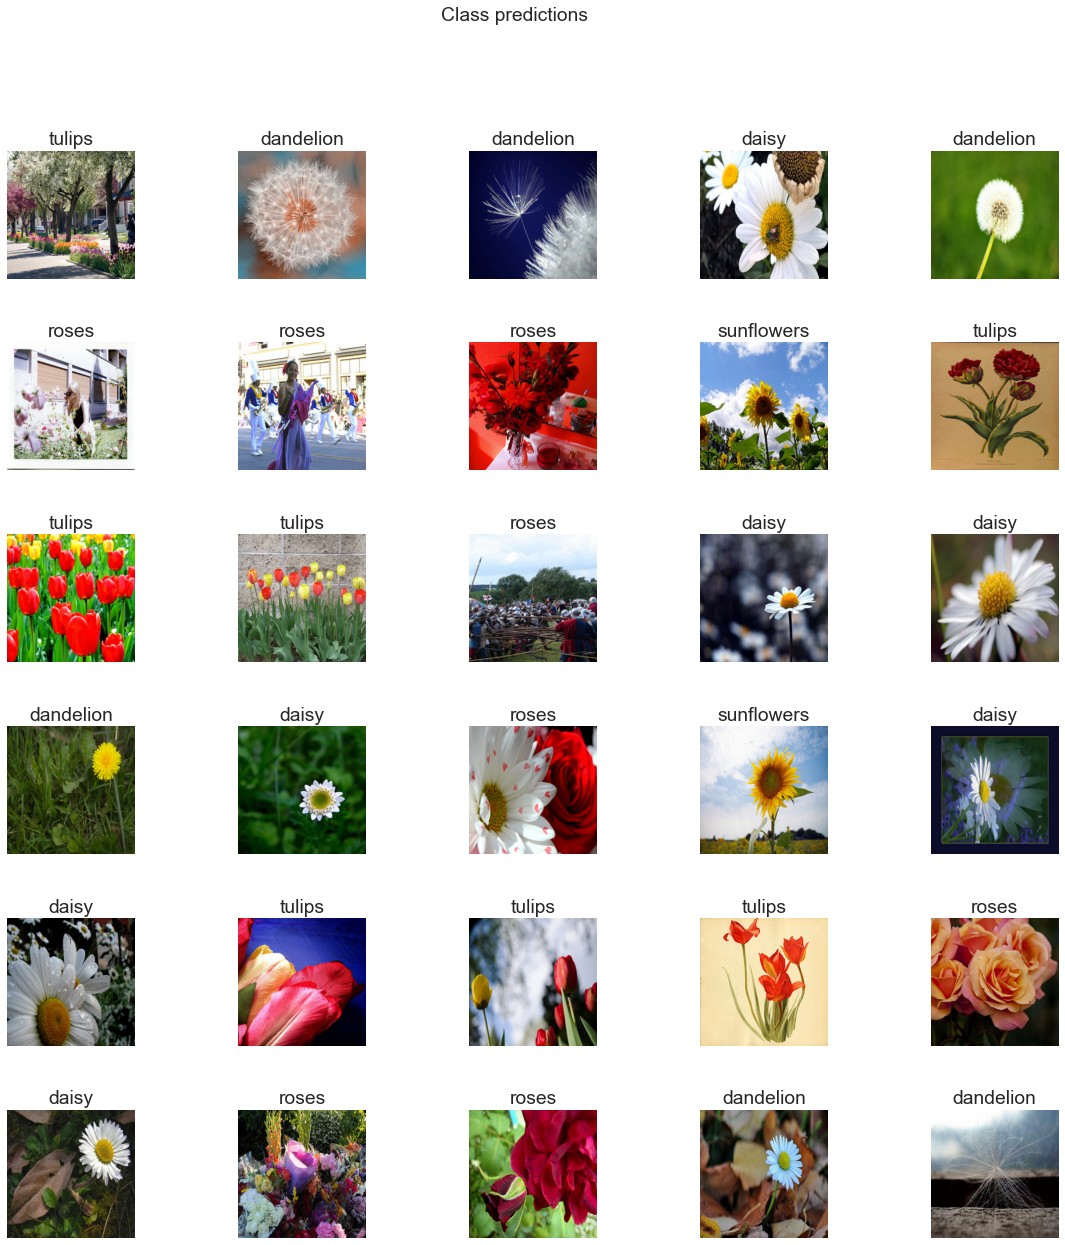

In [21]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(flower_x[n])
  plt.title(preds[n])
  plt.axis('off')
  plt.suptitle("Class predictions")
plt.show()

## 3: Create a readout model from a pretrained network

Let's say you would like to process some images (inputs) with the pretrained net and obtain the net activation values in specific layers of the network (**will need to do in project**). How do you do this with TensorFlow Keras?

You create a **readout model**: a Keras `Model` object that allows you to run a FULL forward pass through the pretained net, but it returns ONLY the netAct values in the layers that YOU specify.

### Create readout model from MobileNetV2

Let's look at the layer summary for MobileNetV2

In [24]:
net = tf.keras.applications.MobileNetV2(input_shape=input_nonbatch_shape,
                                               weights='imagenet')
net.trainable = False
net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Let's get a full list of all the layer names

In [25]:
all_layer_names = []
for layer in net.layers:
    all_layer_names.append(layer.name)
all_layer_names

['input_4',
 'Conv1',
 'bn_Conv1',
 'Conv1_relu',
 'expanded_conv_depthwise',
 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu',
 'expanded_conv_project',
 'expanded_conv_project_BN',
 'block_1_expand',
 'block_1_expand_BN',
 'block_1_expand_relu',
 'block_1_pad',
 'block_1_depthwise',
 'block_1_depthwise_BN',
 'block_1_depthwise_relu',
 'block_1_project',
 'block_1_project_BN',
 'block_2_expand',
 'block_2_expand_BN',
 'block_2_expand_relu',
 'block_2_depthwise',
 'block_2_depthwise_BN',
 'block_2_depthwise_relu',
 'block_2_project',
 'block_2_project_BN',
 'block_2_add',
 'block_3_expand',
 'block_3_expand_BN',
 'block_3_expand_relu',
 'block_3_pad',
 'block_3_depthwise',
 'block_3_depthwise_BN',
 'block_3_depthwise_relu',
 'block_3_project',
 'block_3_project_BN',
 'block_4_expand',
 'block_4_expand_BN',
 'block_4_expand_relu',
 'block_4_depthwise',
 'block_4_depthwise_BN',
 'block_4_depthwise_relu',
 'block_4_project',
 'block_4_project_BN',
 'block_4_add',
 'block_5_e

Let's pick names for a few layers (e.g. 3) from which  we would like to extract netAct values.

In [27]:
selected_layer_names = ['block_3_expand', 'block_6_expand', 'block_9_expand']

Now we make a list of references to the netAct (output) values in each layer

In [28]:
readout_net_acts = []
for layer_name in selected_layer_names:
    readout_net_acts.append(net.get_layer(layer_name).output)
readout_net_acts

[<KerasTensor: shape=(None, 56, 56, 144) dtype=float32 (created by layer 'block_3_expand')>,
 <KerasTensor: shape=(None, 28, 28, 192) dtype=float32 (created by layer 'block_6_expand')>,
 <KerasTensor: shape=(None, 14, 14, 384) dtype=float32 (created by layer 'block_9_expand')>]

Now let's make the readout model object (Keras Model object)

In [29]:
readout_model = tf.keras.Model(inputs=net.input, outputs=readout_net_acts)

### Pass a few flower images through pretrained net, get netAct values from readout model

**Syntax:** You pass the input images through the readout model as if the readout model were the "function" and the input images were the "parameter":

```python
readout_model(input_images)
```

*In Python, passing inputs to an class object like this automatically calls the `__call__(self, inputs)` method in the class. You can override this method in ANY Python class and define how this works!*

In [32]:
# Pass 1st two flower train samples through net. Look at netAct at readout layers.
selected_layer_netActs = readout_model(flower_x[:5])
len(selected_layer_netActs)

3

In [34]:
selected_layer_netActs[1].shape

TensorShape([5, 28, 28, 192])

In [ ]:
print(selected_layer_netActs[-1].shape)

In [35]:
selected_layer_netActs[1][0]

<tf.Tensor: shape=(28, 28, 192), dtype=float32, numpy=
array([[[ 0.52 , -1.732,  0.921, ...,  2.001,  1.954,  2.899],
        [-0.871, -2.763, -0.885, ...,  2.576,  3.701,  1.873],
        [ 1.859, -3.834, -1.658, ...,  0.186, -0.191,  1.262],
        ...,
        [ 0.377, -3.388, -1.958, ..., -2.427,  0.154, -1.568],
        [ 2.423, -3.72 , -0.482, ..., -2.721, -0.542, -2.896],
        [-2.799, -1.328, -2.647, ...,  1.311,  1.179,  2.653]],

       [[ 3.083, -2.515,  3.899, ...,  1.819,  0.96 , -0.895],
        [ 2.458, -3.915, -0.133, ...,  0.484, -1.527,  1.375],
        [ 0.806, -3.888, -3.499, ..., -1.375, -1.285,  3.13 ],
        ...,
        [ 0.231, -4.589, -0.233, ...,  0.246, -1.434, -2.05 ],
        [ 2.561, -4.217,  0.205, ..., -1.478, -1.32 , -2.911],
        [-2.026, -3.005, -0.565, ..., -1.44 ,  0.297, -2.295]],

       [[ 1.745, -2.863,  2.43 , ...,  2.314,  0.233, -1.43 ],
        [ 1.902, -3.577, -0.47 , ...,  1.604,  0.711, -0.179],
        [ 1.531, -3.959,  3.01 , 

## 4: TensorFlow's low-level API

**Pros of low-level API:**
- Numpy-like flexibility with designing your network, with library access to common netAct/loss functions.
- Can implement whatever layer/net connectivity and training protocol/bells/whistles that you like
- Can write Numpy-like code to do anything you would do with Numpy, but have your code **GPU accelerated**.

**Cons of low-level API:**
- Even though netIn/netAct calculations are relatively easy to implement as the programmer, you still need to write lots of boilerplate code every time (e.g. initialize wt/bias tensors, record gradients/unpack them, write main training loop, etc.). 

## 4a. Tensorflow's Tensor datatype

Let's go over how to create a tensor and perform some common operations.

### Creating a tensor

In [37]:
# zeros
a = tf.zeros(shape=(10,3))
a

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

In [38]:
# ones
tf.ones([3, 4])

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)>

In [43]:
# random: gaussian
tf.random.normal(shape=(5,5), mean=0, stddev=1)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[-1.525,  1.417, -1.667, -0.966,  0.238],
       [ 0.933,  0.251,  0.402, -0.551,  0.254],
       [-0.031, -0.029,  2.375, -0.321, -0.972],
       [ 1.172, -1.389, -0.578, -1.462,  0.813],
       [ 0.296, -0.643,  0.295,  0.432,  0.443]], dtype=float32)>

In [48]:
# random: uniform float. Specify minval/maxval
tf.random.uniform(shape=(3, 5), minval=-5, maxval=10)

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.237, -4.313,  0.567, -4.542, -3.061],
       [ 8.13 , -1.98 ,  6.673, -4.559, -4.28 ],
       [-4.833,  4.032,  5.278,  3.555,  4.108]], dtype=float32)>

In [55]:
# random: uniform int
tf.random.uniform(shape=(3, 5), minval=-5, maxval=10, dtype=tf.int32)

<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[-4, -5, -4,  2,  5],
       [ 2,  4,  6,  0, -2],
       [-2, -3,  2,  8,  6]], dtype=int32)>

In [57]:
# Creating a tf tensor based on a int/float
my_tensor = tf.constant(3)
my_tensor

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [59]:
# Creating a tf tensor based on a python list
my_tensor = tf.constant([1, 2, 3])
my_tensor

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [62]:
# create tensor from numpy ndarray
randNums = np.random.randn(5,5)
print('Numpy version:\n',randNums)
tfNums = tf.constant(randNums)
print('TensorFlow version:\n',tfNums)

Numpy version:
 [[ 0.329  0.693 -0.767  1.673  0.358]
 [ 0.065 -0.355  0.645  0.191 -1.218]
 [ 0.634  0.112  0.936 -2.27   0.129]
 [-1.241  1.398  1.109  0.673  0.824]
 [-0.524  0.282 -1.221  0.545 -0.359]]
TensorFlow version:
 tf.Tensor(
[[ 0.329  0.693 -0.767  1.673  0.358]
 [ 0.065 -0.355  0.645  0.191 -1.218]
 [ 0.634  0.112  0.936 -2.27   0.129]
 [-1.241  1.398  1.109  0.673  0.824]
 [-0.524  0.282 -1.221  0.545 -0.359]], shape=(5, 5), dtype=float64)


### Basic operations

In [64]:
# printing
tf.print(tfNums)

[[0.328867720412224 0.6927333870600384 -0.76691781373920465 1.6730020767072022 0.35802763474321236]
 [0.064924222009212426 -0.35492320480552619 0.64549967757206972 0.191206760311099 -1.2181912677232376]
 [0.63393907328988264 0.11227706027354 0.936216944433744 -2.2699787249349241 0.12928295640855189]
 [-1.2406598000183928 1.3977337393395535 1.1094652450180227 0.67294896041720043 0.82394188096320209]
 [-0.52391448921288175 0.28227563983704596 -1.2206575714381553 0.54497081269258951 -0.35865110957978319]]


In [65]:
# converting a tf tensor to a numpy array
backToNp = tfNums.numpy()
print(backToNp) # this is a np ndarray

[[ 0.329  0.693 -0.767  1.673  0.358]
 [ 0.065 -0.355  0.645  0.191 -1.218]
 [ 0.634  0.112  0.936 -2.27   0.129]
 [-1.241  1.398  1.109  0.673  0.824]
 [-0.524  0.282 -1.221  0.545 -0.359]]


In [66]:
backToNp

array([[ 0.329,  0.693, -0.767,  1.673,  0.358],
       [ 0.065, -0.355,  0.645,  0.191, -1.218],
       [ 0.634,  0.112,  0.936, -2.27 ,  0.129],
       [-1.241,  1.398,  1.109,  0.673,  0.824],
       [-0.524,  0.282, -1.221,  0.545, -0.359]])

In [3]:
# generate range
range_tf = tf.range(0, 10)
range_tf

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [70]:
# arithmetic: adding
range_tf + range_tf

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18], dtype=int32)>

In [71]:
# subtracting
range_tf - range_tf

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [73]:
# multiplication/division
range_tf / 3

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.   , 0.333, 0.667, 1.   , 1.333, 1.667, 2.   , 2.333, 2.667,
       3.   ])>

In [74]:
# matrix multiplcation
a = tf.random.uniform(shape=(3, 5))
b = tf.random.uniform(shape=(5, 9))
c = a @ b
c

<tf.Tensor: shape=(3, 9), dtype=float32, numpy=
array([[0.927, 1.612, 1.582, 1.502, 0.43 , 1.025, 1.128, 1.363, 1.55 ],
       [1.149, 1.063, 1.401, 1.037, 0.649, 0.664, 0.862, 1.14 , 1.23 ],
       [0.929, 1.236, 1.333, 1.164, 0.529, 0.772, 0.832, 1.126, 1.129]],
      dtype=float32)>

#### Assignment

In [4]:
# You slice like python
print(range_tf)
range_tf[1:3]

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [5]:
# but you cannot do assignment like python. crash:
range_tf[0] = 99
# Avoid assigning parts of a tensor...it's a headache
# Remember: by default a tensor is a tf.constant!
# TensorFlow has another type of tensor that can be modified (but not by =)...
# More on this later!

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [79]:
# Logical indexing!
range_tf[range_tf < 5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 2, 3, 4], dtype=int32)>

In [81]:
# assignment hack: use tf.where. e.g. replace the value 0 with 100 in a tensor
new_tensor = tf.where(range_tf < 5, 99, range_tf)
print(range_tf)
print(new_tensor)

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)
tf.Tensor([99 99 99 99 99  5  6  7  8  9], shape=(10,), dtype=int32)


#### Memory

In [7]:
# noteworthy memory point so you're aware:
# Taking a tensor and modifying it via arithmetic creates a NEW tensor in memory
range_tf = range_tf + 2
range_tf

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)>

#### Checking shapes

In [8]:
# Make 2x3x4x5 tensor
test = tf.ones(shape=(2,3,4,5))

# Checking shapes
test.shape

TensorShape([2, 3, 4, 5])

In [9]:
# can slice TensorShape objects as you'd expect
test.shape[1:3]

TensorShape([3, 4])

In [11]:
test.shape + 2 # not what you might expect!

TensorShape([2, 3, 4, 5, 2])

In [15]:
# use as_list() method to get a python list of shape back
test.shape.as_list()

[2, 3, 4, 5]

In [16]:
# or call Python list() function on it to cast0
list(test.shape)

[2, 3, 4, 5]

Checking the number of dimensions in a tensor

In [17]:
test.ndim

4

#### Casting dataypes

TensorFlow is more strict about datatypes than Numpy. It might complain if you try to add/subtract/multiply/etc a `tf.float32` tensor with a `tf.double` tensor. Casting is therefore useful!

In [21]:
tf.transpose(b)

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])>

In [23]:
# Mat mult example
a = tf.ones(shape=(3, 5))
print(a)
b = tf.ones(shape=(3, 5), dtype=tf.double)
print(b)

# a @ tf.transpose(b) # crash
a @ tf.cast(tf.transpose(b), tf.float32)

tf.Tensor(
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]], shape=(3, 5), dtype=float64)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.]], dtype=float32)>

**Rule of thumb:** `tf.float32` is common so cast to that if in doubt.

Many tensor construction methods support dtype keyword argument so that you don't need to cast afterward making a tensor (i.e. generate the data with the correct type).

In [24]:
# example: ones as tf.int32 instead of float
tf.ones(shape=(3, 5), dtype=tf.int32)

<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int32)>

### Useful operations for neural networks

#### Reduce

In [26]:
# often you have a multi-dimensional tensor and want to sum up all elements into a single
# scalar value (reduce)
t = tf.ones(shape=(5, 5, 5))
tf.reduce_mean(t)
tf.reduce_mean(t, axis=1)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [30]:
# can do mean, max, min, etc
randT = tf.random.uniform(shape=(100, 10))
tf.reduce_max(randT)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99356985>

In [ ]:
# Each reduce command supports an axis like numpy
ran = tf.random.normal(shape=(3,4,5))


#### clip values outside a range

In [33]:
randData = tf.random.uniform(shape=(10, 10))
print(randData)
print(tf.clip_by_value(randData, clip_value_min=0.2, clip_value_max=0.8))

tf.Tensor(
[[0.777 0.146 0.512 0.49  0.255 0.245 0.154 0.865 0.591 0.065]
 [0.88  0.524 0.032 0.29  0.026 0.173 0.502 0.447 0.832 0.201]
 [0.981 0.15  0.267 0.482 0.184 0.709 0.981 0.264 0.156 0.34 ]
 [0.222 0.846 0.919 0.519 0.654 0.63  0.832 0.509 0.284 0.52 ]
 [0.378 0.549 0.926 0.859 0.663 0.339 0.511 0.196 0.255 0.175]
 [0.719 0.579 0.619 0.889 0.976 0.45  0.051 0.554 0.374 0.117]
 [0.616 0.601 0.159 0.346 0.789 0.165 0.2   0.194 0.443 0.531]
 [0.386 0.368 0.066 0.697 0.641 0.644 0.337 0.735 0.9   0.997]
 [0.33  0.593 0.941 0.21  0.347 0.864 0.36  0.065 0.482 0.723]
 [0.734 0.571 0.531 0.208 0.614 0.048 0.867 0.633 0.371 0.463]], shape=(10, 10), dtype=float32)
tf.Tensor(
[[0.777 0.2   0.512 0.49  0.255 0.245 0.2   0.8   0.591 0.2  ]
 [0.8   0.524 0.2   0.29  0.2   0.2   0.502 0.447 0.8   0.201]
 [0.8   0.2   0.267 0.482 0.2   0.709 0.8   0.264 0.2   0.34 ]
 [0.222 0.8   0.8   0.519 0.654 0.63  0.8   0.509 0.284 0.52 ]
 [0.378 0.549 0.8   0.8   0.663 0.339 0.511 0.2   0.255 0.2  ]


#### Adding a singleton (batch) dimension

In [37]:
randData[None, :  :]

<tf.Tensor: shape=(1, 10, 10), dtype=float32, numpy=
array([[[0.777, 0.146, 0.512, 0.49 , 0.255, 0.245, 0.154, 0.865, 0.591,
         0.065],
        [0.88 , 0.524, 0.032, 0.29 , 0.026, 0.173, 0.502, 0.447, 0.832,
         0.201],
        [0.981, 0.15 , 0.267, 0.482, 0.184, 0.709, 0.981, 0.264, 0.156,
         0.34 ],
        [0.222, 0.846, 0.919, 0.519, 0.654, 0.63 , 0.832, 0.509, 0.284,
         0.52 ],
        [0.378, 0.549, 0.926, 0.859, 0.663, 0.339, 0.511, 0.196, 0.255,
         0.175],
        [0.719, 0.579, 0.619, 0.889, 0.976, 0.45 , 0.051, 0.554, 0.374,
         0.117],
        [0.616, 0.601, 0.159, 0.346, 0.789, 0.165, 0.2  , 0.194, 0.443,
         0.531],
        [0.386, 0.368, 0.066, 0.697, 0.641, 0.644, 0.337, 0.735, 0.9  ,
         0.997],
        [0.33 , 0.593, 0.941, 0.21 , 0.347, 0.864, 0.36 , 0.065, 0.482,
         0.723],
        [0.734, 0.571, 0.531, 0.208, 0.614, 0.048, 0.867, 0.633, 0.371,
         0.463]]], dtype=float32)>

In [36]:
randData[tf.newaxis, :  :]

<tf.Tensor: shape=(1, 10, 10), dtype=float32, numpy=
array([[[0.777, 0.146, 0.512, 0.49 , 0.255, 0.245, 0.154, 0.865, 0.591,
         0.065],
        [0.88 , 0.524, 0.032, 0.29 , 0.026, 0.173, 0.502, 0.447, 0.832,
         0.201],
        [0.981, 0.15 , 0.267, 0.482, 0.184, 0.709, 0.981, 0.264, 0.156,
         0.34 ],
        [0.222, 0.846, 0.919, 0.519, 0.654, 0.63 , 0.832, 0.509, 0.284,
         0.52 ],
        [0.378, 0.549, 0.926, 0.859, 0.663, 0.339, 0.511, 0.196, 0.255,
         0.175],
        [0.719, 0.579, 0.619, 0.889, 0.976, 0.45 , 0.051, 0.554, 0.374,
         0.117],
        [0.616, 0.601, 0.159, 0.346, 0.789, 0.165, 0.2  , 0.194, 0.443,
         0.531],
        [0.386, 0.368, 0.066, 0.697, 0.641, 0.644, 0.337, 0.735, 0.9  ,
         0.997],
        [0.33 , 0.593, 0.941, 0.21 , 0.347, 0.864, 0.36 , 0.065, 0.482,
         0.723],
        [0.734, 0.571, 0.531, 0.208, 0.614, 0.048, 0.867, 0.633, 0.371,
         0.463]]], dtype=float32)>

In [38]:
result = tf.expand_dims(randData, axis=0)

#### squeeze

In [40]:
# squeeze works too
tf.squeeze(result).shape

TensorShape([10, 10])

## 4b. Building a neural network with Tensorflow's low-level API

Let's build a MLP with the low-level Tensorflow API and do a forward pass.
Let's have the following layers:

    Dense netIn / ReLu netAct ->
    Dense netIn / Sigmoid netAct ->
    Dense netIn / Softmax netAct (input has C classes)

MLP, forward, loss, gradient tape

### Dummy image input

**TODO**:
- For input, let's make some random images.
- For classes `y`, let's pick random numbers from `C=10` classes

**NOTE:** One oddity is that Tensorflow likes the color channel in this format `(img_y, img_x, n_chans)`. We of course have been using `(n_chans, img_y, img_x)`, which is the convention for other neural network APIs (e.g. PyTorch and others). There is no "right" way: we just need to remember to be flexible in our ways :)

In [41]:
N = 20
img_y = 32
img_x = 32
n_chans = 3
C = 10

# gaussian inputs
inputs = tf.random.normal(shape=(N, img_y, img_x, n_chans))

# classes need to be ints, Nx1 for broadcast-ability later on
y = tf.random.uniform(shape=(N, 1), maxval=C, dtype=tf.int32)

print(f'Inputs have shape {inputs.shape}')
print(f'Class assignments:\n{y}')

Inputs have shape (20, 32, 32, 3)
Class assignments:
[[7]
 [5]
 [4]
 [1]
 [8]
 [3]
 [2]
 [9]
 [0]
 [0]
 [5]
 [1]
 [5]
 [3]
 [9]
 [6]
 [5]
 [6]
 [7]
 [2]]


### Flatten non-batch dims

Like any MLP, we can only pass in 1D non-batch features. We need to flatten non-batch dims. Let's write a simple function to do this

In [45]:
def flatten(x):
    '''Flattens non-batch dims of input
    
    Parameters:
    -----------
    x: tf tensor. shape=(N, dim1, dim2, dim3, ...)
    
    Returns:
    -----------
    xf: tf tensor. shape=(N, dim1*dim2*dim3*...)
    '''
    return tf.reshape(x, [x.shape[0], tf.reduce_prod(x.shape[1:])])
#     return tf.reshape(x, [x.shape[0], -1])

In [46]:
# Define 'features' to be flattened inputs
features = flatten(inputs)
features.shape

TensorShape([20, 3072])

In [47]:
# for convenience, define variable for num_features
M = features.shape[1]  # M
M

3072

### Define hyperparameters for network architecture

In [48]:
H1 = 10# num hidden units in L1 (1st hidden layer)
H2 = 30# num hidden units in L2 (2nd hidden layer)

### Define wts and bias for each layer

3 sets of Gaussian random wts and bias for `l1`, `l2` and `l3` (output layer)

MLP: inputs= (N, M)

wts: (M, H)

Hidden layer activation/net_ins = (N, H1)

**Important:** We need to "tell" TensorFlow about any variables that we are interested in taking gradients of in our network. We do this by wrapping (converting) a tensor with `tf.Variable`.

In [50]:
l1_wts = tf.Variable(tf.random.normal(shape=(M, H1)))
l1_b = tf.Variable(tf.random.normal(shape=(H1,)))

l2_wts = tf.Variable(tf.random.normal(shape=(H1, H2)))
l2_b = tf.Variable(tf.random.normal(shape=(H2,)))

l3_wts = tf.Variable(tf.random.normal(shape=(H2, C)))
l3_b = tf.Variable(tf.random.normal(shape=(C,)))

### Do forward pass, compute loss

Notes:
- Remember, `Dense` is just a dot product (aka matrix multiply)
- `tf.nn` has lots of activation functions


#### Summary of network

    Dense netIn / ReLu netAct ->
    Dense netIn / Sigmoid netAct ->
    Dense netIn / Softmax netAct (input has C classes)

In [54]:
# Layer 1: Dense netIn
l1_netin = features @ l1_wts + l1_b
# Layer 1: ReLU
l1_netact = tf.nn.relu(l1_netin)
# Layer 2: Dense netIn
l2_netin = l1_netact @ l2_wts + l2_b
# Layer 2: Sigmoid
l2_netact = tf.nn.sigmoid(l2_netin)
# Layer 3: Dense netIn
l3_netin = l2_netact @ l3_wts + l3_b
# Layer 3: Softmax
l3_netact = tf.nn.softmax(l3_netin)

In [55]:
l3_netact.shape # N, C

TensorShape([20, 10])

In [56]:
# probs that input 0 is of the 10 classes
l3_netact[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.   , 0.028, 0.   , 0.005, 0.133, 0.038, 0.009, 0.005, 0.781,
       0.002], dtype=float32)>

In [57]:
# Sum of all net_acts?
tf.reduce_sum(l3_netact[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

**NOTE:**

- The common cross-entopy function in Tensorflow (`tf.nn.softmax_cross_entropy_with_logits(y, out_netIn)`) does the softmax calculation AND the cross-entropy calculation together. Therefore, we should pass it the outlayer layer NET_IN values, NOT the NET_ACT values (we could just not compute the NET_ACT ourselves).
- This tensorflow loss function returns the loss PER SAMPLE. We need to average them across the batch ourselves

In [59]:
# compute softmax and cross-entropy loss
loss = tf.nn.softmax_cross_entropy_with_logits(y, l3_netin)
print(loss)
tf.reduce_mean(loss)

tf.Tensor(
[389.969 319.098 262.631  64.994 347.821 117.651 155.877 397.315   0.
   0.    250.677  40.421 443.829 130.494 402.645 340.308 306.397 236.034
 332.999  98.239], shape=(20,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=231.86992>

### Full forward and backward pass

#### Let's copy-paste forward code (minus output netAct) into the following function

In [60]:
def forward(features, l1_wts, l1_b, l2_wts, l2_b, l3_wts, l3_b):
    # Layer 1: Dense netIn
    l1_netin = features @ l1_wts + l1_b
    # Layer 1: ReLU
    l1_netact = tf.nn.relu(l1_netin)
    # Layer 2: Dense netIn
    l2_netin = l1_netact @ l2_wts + l2_b
    # Layer 2: Sigmoid
    l2_netact = tf.nn.sigmoid(l2_netin)
    # Layer 3: Dense netIn
    l3_netin = l2_netact @ l3_wts + l3_b
    return l3_netin

#### Backward pass

**SURPRISE:** Tensorflow computes the gradients automatically for us if we compute the forward pass while in 'gradient recording mode' (`GradientTape` block). 

This magic is called **reverse-mode automatic differentiation**:
- Tensorflow creates a graph of all weight/bias variables (like the network diagrams we often draw in class).
- As you compute forward pass, it records which operations/functions affect nodes in the graph.
- When it's done, it does backprop (similar to how we learned it): `d_upstream` * `partial derivative of current node in graph` to move to that node in the graph.

**Caveat:** To make a node in the graph, tensorflow needs a `tf.Variable`. This is why we needed to wrap the wts/bias in `tf.Variable`.

**TODO**
- Do forward pass, compute loss in a `GradientTape` session, get all the gradients

In [64]:
with tf.GradientTape() as tape:
    l3_netin = forward(features, l1_wts, l1_b, l2_wts, l2_b, l3_wts, l3_b)
    losses = tf.nn.softmax_cross_entropy_with_logits(y, l3_netin)
    loss = tf.reduce_mean(losses)
# get grads for each layer of wts/b
grads = tape.gradient(loss, (l1_wts, l1_b, l2_wts, l2_b, l3_wts, l3_b))

In [67]:
grads[-1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-4.4  , -4.23 , -4.399, -4.302, -4.302, -4.287, -4.341, -4.381,
       -4.297, -4.061], dtype=float32)>

In [69]:
# e.g. check shape of l3_b and d_l3_b
print(l3_b.shape)
print(grads[-1].shape)
print(l3_wts.shape)
print(grads[-2].shape)

(10,)
(10,)
(30, 10)
(30, 10)


In [70]:
grads[-2]

<tf.Tensor: shape=(30, 10), dtype=float32, numpy=
array([[-1.807, -1.701, -1.806, -1.744, -1.802, -1.746, -1.789, -1.803,
        -1.785, -1.663],
       [-1.59 , -1.479, -1.59 , -1.576, -1.523, -1.549, -1.574, -1.586,
        -1.581, -1.514],
       [-3.237, -3.083, -3.237, -3.218, -3.161, -3.167, -3.211, -3.222,
        -3.213, -2.982],
       [-0.977, -0.97 , -0.977, -0.898, -0.96 , -0.958, -0.946, -0.974,
        -0.957, -0.877],
       [-3.7  , -3.659, -3.7  , -3.623, -3.603, -3.619, -3.659, -3.685,
        -3.633, -3.419],
       [-2.55 , -2.529, -2.55 , -2.49 , -2.467, -2.51 , -2.53 , -2.538,
        -2.492, -2.394],
       [-4.4  , -4.23 , -4.399, -4.302, -4.302, -4.287, -4.341, -4.381,
        -4.297, -4.061],
       [-1.15 , -1.134, -1.15 , -1.149, -1.08 , -1.139, -1.15 , -1.147,
        -1.149, -0.999],
       [-3.075, -2.986, -3.075, -3.014, -2.988, -3.001, -3.044, -3.058,
        -3.051, -2.885],
       [-3.897, -3.728, -3.896, -3.858, -3.802, -3.791, -3.857, -3.879,
     

##### Update wts using gradients

- Re-execute original backward pass cell.
- Loop thru wts/bias and corresponding gradients, update the weights via gradient descent.


###### NOTE about -=
- **Does't exist in TensorFlow!**
- `thing = thing - d_thing` doesn't mutate (change) `thing` it copies everything over as a new object in memory. This is wasteful.
- If `thing` is a `tf.Variable`, we can update its value via `thing.assign_sub(d_thing)` (-=). ("sub" for subtract. There is a `assign_add` for addition).

In [74]:
# SGD with lr=0.1. Run on l3_b
lr = 0.1
print('Before:')
print(l3_b)
l3_b.assign_add(-lr*grads[-1])
print('After:')
print(l3_b)

Before:
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([-0.326,  0.793,  0.776,  2.793,  2.424,  1.529,  1.611,  0.213,
        0.789, -1.446], dtype=float32)>
After:
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 0.114,  1.216,  1.216,  3.224,  2.854,  1.957,  2.045,  0.651,
        1.219, -1.04 ], dtype=float32)>


In [77]:
print('Before:')
print(l3_wts[:10])
l3_wts.assign_add(-lr*grads[-2])
print('After:')
print(l3_wts[:10])

Before:
tf.Tensor(
[[ 0.493 -0.633  0.76   1.185 -1.211  0.614 -0.136  1.231 -0.045 -0.06 ]
 [ 0.771  1.346  0.205  0.556  1.866  1.465  1.161  0.399 -0.411  2.09 ]
 [ 0.685  2.28  -0.189  0.162  0.453  0.021 -0.069  2.12   0.048  1.414]
 [ 0.355  1.323  1.189  0.455  1.428 -0.533 -0.327 -0.365  0.344  0.323]
 [ 0.492  0.596  2.308  0.669  2.415  0.33  -0.348  2.385  1.402  1.607]
 [-0.517 -1.132  1.37  -0.357  0.727  0.706  1.004  0.979  1.571 -0.799]
 [ 0.401  2.116  0.387  1.533  0.844 -0.484  2.518  0.796  2.867  0.482]
 [ 1.099  0.408 -1.087  0.195 -0.891  0.635 -0.134 -0.641 -0.182  0.754]
 [ 1.063  0.34   0.926  1.214  0.737  2.094  1.219  1.81  -0.554  0.859]
 [ 0.404  2.064 -0.318 -0.16   1.372  0.244  0.516  1.159  0.235  1.295]], shape=(10, 10), dtype=float32)
After:
tf.Tensor(
[[ 0.673 -0.463  0.941  1.36  -1.031  0.789  0.043  1.411  0.133  0.106]
 [ 0.93   1.494  0.364  0.713  2.019  1.62   1.319  0.558 -0.253  2.241]
 [ 1.008  2.588  0.135  0.484  0.769  0.337  0.252  2.

In [81]:
# print(l3_wts[:5])
# l3_wts.assign_add(5*tf.ones(1,))
# print(l3_wts[:5])

##### Use built-in optimizer to update wts

Let's use Adam to update the wts instead of SGD

In [82]:
my_opt = tf.optimizers.Adam(learning_rate=0.01)

Useful to use Python `zip` function to form tuples for all parameters and gradients:

```python
[(dl1_wts, l1_wts), (dl1_b, l1_b), (dl2_wts, l2_wts), ...]
```

In [85]:
all_params = (l1_wts, l1_b, l2_wts, l2_b, l3_wts, l3_b)
print('Before')
print(l3_b)
my_opt.apply_gradients(zip(grads, all_params))
print('After')
print(l3_b)

Before
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 0.134,  1.236,  1.236,  3.244,  2.874,  1.977,  2.065,  0.671,
        1.239, -1.02 ], dtype=float32)>
After
<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 0.144,  1.246,  1.246,  3.254,  2.884,  1.987,  2.075,  0.681,
        1.249, -1.01 ], dtype=float32)>


### Note for project:
- If doing conv2d early in the network, remember to use 'SAME' boundary conditions and to flatten non-batch dims before entering `Dense` layers (like in Project 3).

## 5. Appendix: Other TensorFlow

### Selecting values by indices

#### Chunks of values in 1+ axis: tf.gather

Slicing works like numpy â€” but what if you want to index into non-contiguous indices? e.g. at index 3 and 5 for axis=2?

Example: 
Original tensor shape=(3,4,**6**,7)

Goal (after indexing): shape=(3,4,**2**,7)

(if this were 2D, like selecting all rows, but only 2 columns)

In [ ]:
tf.random.set_seed(0)
myTensor = tf.random.normal(shape=(3, 4, 6, 7))

myTensor[0,0,3]

In [ ]:
print(myTensor.shape)

# Use tf.gather to get data with indices [3, 5] in axis 2
myTensorSelected = tf.gather(myTensor, [3, 5], axis=2)
myTensorSelected.shape

#### Indiviual elements: tf.gather_nd

Slightly different problem: Select a list of **individual elements** from a tensor.

Specify by a list of subscript indices (e.g. [0,0,0] to access top left element of a 3D tensor).

In [ ]:
# test has shape=(2,2,2)
test = tf.constant([[[10, 11], [12, 13]], [[99, 100], [101, 102]]])
tf.print(test)
tf.print(test.shape)

# Use tf.gather_nd to get data with indices (x, y, z) = (0, 0, 0) and (1, 1, 1)
tf.gather_nd(test, [[0,0,0], [1,1,1]])